In [ ]:
import os
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import log_loss, roc_auc_score, roc_curve, make_scorer, brier_score_loss
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve

from joblib import dump, load
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def mcfadden_r2(y, y_pred):
    ll = log_loss(y, y_pred)
    ll_null = log_loss(y, np.full(len(y), y.mean()))
    return 1 - (ll/ll_null)
pseudo_r2_scorer = make_scorer(mcfadden_r2, needs_proba=True, greater_is_better=True)
scoring = {'roc_aug': 'roc_auc', 'mcfaddens_r2': pseudo_r2_scorer}

In [ ]:
cwd = os.getcwd()
df = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))

In [ ]:
df.drop(['match_id', 'statsbomb_id', 'statsbomb_team_id', 'player_id_statsbomb', 'competition_gender', 'team_name',
         'player_id', 'firstName', 'middleName', 'lastName', 'Name', 'dataset', 'wyscout_id', 'wyscout_team_id', 'team_id',
         'player_id_wyscout','competition_name','minute','shot_zone','match_week','pass_end_y',
         'goalkeeper_x', 'goalkeeper_y', 'carry_length', 'shot_one_on_one', 'shot_open_goal','under_pressure', 'area_shot', 
         'area_goal', 'n_angle', 'smart_pass','pass_end_x'], axis=1, inplace=True)
mask_penalty = (df.shot_type_name=='penalty')
df_penalty = df[mask_penalty].copy()
df_penalty.drop(['x','y','visible_angle','middle_angle','distance_to_goal','distance_visible_angle','log_distance_to_goal',
                 'assist_type', 'pass_switch', 'pass_cross', 'pass_cut_back','counter_attack', 'pass_height_name',
                 'pass_technique_name', 'shot_zone_number','shot_zone_player_number','fast_break', 'strong_foot',
                 'body_part_name','shot_type_name'], axis=1, inplace=True)
df_non_penalty = df[~mask_penalty].copy()

In [ ]:
def split(X):
    mask = X.assist_type == 'pass'
    X_pass = X[mask].drop('assist_type', axis=1).copy()
    X_other = X[~mask].dropna(axis=1, how='all').copy()
    return X_pass, X_other

In [ ]:
df_np_pass,  df_np_other = split(df_non_penalty)

In [ ]:
df_np_pass = pd.get_dummies(df_np_pass, columns=['competition_type','competition_part','H_A_column','match_moment',
                                                 'shot_type_name', 'body_part_name','pass_technique_name','pass_height_name'])
df_np_other = pd.get_dummies(df_np_other, columns=['competition_type','competition_part','H_A_column','match_moment',
                                                   'assist_type','shot_type_name', 'body_part_name'])
df_p = pd.get_dummies(df_penalty, columns=['competition_type','competition_part','H_A_column','match_moment'])
y_np_pass = df_np_pass['goal']
x_np_pass = df_np_pass.drop(['goal'], axis=1)
x_npp_train, x_npp_test, y_npp_train, y_npp_test = train_test_split(x_np_pass, y_np_pass, test_size=0.2, random_state=42)
y_np_other = df_np_other['goal']
x_np_other = df_np_other.drop(['goal'], axis=1)
x_npo_train, x_npo_test, y_npo_train, y_npo_test = train_test_split(x_np_other, y_np_other, test_size=0.2, random_state=42)
y_p = df_p['goal']
x_p = df_p.drop(['goal'], axis=1)
x_p_train, x_p_test, y_p_train, y_p_test = train_test_split(x_p, y_p, test_size=0.2, random_state=42)

In [8]:
logreg = LogisticRegression(multi_class='multinomial', solver='saga')
rfe_npp = RFE(logreg, 24)
rfe_npp = rfe_npp.fit(x_npp_train, y_npp_train)

x_npp_train = x_npp_train.loc[:, rfe_npp.support_]
x_npp_test = x_npp_test.loc[:, rfe_npp.support_]

In [9]:
logistic_regression_npp = sm.GLM(endog=y_npp_train.astype(float),exog=x_npp_train.astype(float),data=df_np_pass,
                                           family=sm.families.Binomial()).fit()

In [10]:
train_y_npp_hat = logistic_regression_npp.predict(x_npp_train.astype(float))
y_pred_lr_npp = logistic_regression_npp.predict(x_npp_test.astype(float))
naive_train_log_loss_npp = log_loss(y_npp_train, train_y_npp_hat)
naive_train_roc_auc_npp = roc_auc_score(y_npp_train, train_y_npp_hat)
print('The log loss of our non-penalty pass model on the training set is : ' +str(round(naive_train_log_loss_npp, 4)))
print('The ROC AUC of our non-penalty pass model on the training set is : ' +str(round(naive_train_roc_auc_npp, 4)))
print("McFadden's Pseudo R-squared shots assisted by passes : "  +str(round( mcfadden_r2(y_npp_train, train_y_npp_hat), 4)))

The log loss of our non-penalty pass model on the training set is : 0.2922
The ROC AUC of our non-penalty pass model on the training set is : 0.7833
McFadden's Pseudo R-squared shots assisted by passes : 0.16


In [13]:
print(logistic_regression_npp.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                35198
Model:                            GLM   Df Residuals:                    35175
Model Family:                Binomial   Df Model:                           22
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10284.
Date:                Tue, 07 Sep 2021   Deviance:                       20567.
Time:                        10:14:16   Pearson chi2:                 3.45e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
visibl

In [ ]:
rfe_npo = RFE(logreg, 24)
rfe_npo = rfe_npo.fit(x_npo_train, y_npo_train)

x_npo_train = x_npo_train.loc[:, rfe_npo.support_]
x_npo_test = x_npo_test.loc[:, rfe_npo.support_]

In [ ]:
logistic_regression_npo = sm.GLM(endog=y_npo_train.astype(float),exog=x_npo_train.astype(float),data=df_np_other,
                                           family=sm.families.Binomial()).fit()

In [11]:
train_y_npo_hat = logistic_regression_npo.predict(x_npo_train.astype(float))
y_pred_lr_npo = logistic_regression_npo.predict(x_npo_test.astype(float))
naive_train_log_loss_npo = log_loss(y_npo_train, train_y_npo_hat)
naive_train_roc_auc_npo = roc_auc_score(y_npo_train, train_y_npo_hat)
print('The log loss of our non-penalty other model on the training set is : ' +str(round(naive_train_log_loss_npo, 4)))
print('The ROC AUC of our non-penalty other model on the training set is : ' +str(round(naive_train_roc_auc_npo, 4)))
print("McFadden's Pseudo R-squared shots assisted by passes : "  +str(round( mcfadden_r2(y_npp_train, train_y_npp_hat), 4)))

The log loss of our non-penalty other model on the training set is : 0.2609
The ROC AUC of our non-penalty other model on the training set is : 0.8078
McFadden's Pseudo R-squared shots assisted by passes : 0.16


In [14]:
print(logistic_regression_npo.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                16406
Model:                            GLM   Df Residuals:                    16384
Model Family:                Binomial   Df Model:                           21
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4280.5
Date:                Tue, 07 Sep 2021   Deviance:                       8561.1
Time:                        10:14:16   Pearson chi2:                 1.65e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
visible_an

In [ ]:
rfe_p = RFE(logreg, 10)
rfe_p = rfe_p.fit(x_p_train, y_p_train)

x_p_train = x_p_train.loc[:, rfe_p.support_]
x_p_test = x_p_test.loc[:, rfe_p.support_]

In [ ]:
logistic_regression_p = sm.GLM(endog=y_p_train.astype(float),exog=x_p_train.astype(float),data=df_p,
                                           family=sm.families.Binomial()).fit()

In [12]:
train_y_p_hat = logistic_regression_p.predict(x_p_train.astype(float))
naive_train_log_loss_p = log_loss(y_p_train, train_y_p_hat)
naive_train_roc_auc_p = roc_auc_score(y_p_train, train_y_p_hat)
print('The log loss of our penalty model on the training set is : ' +str(round(naive_train_log_loss_p, 4)))
print('The ROC AUC of our penalty model on the training set is : ' +str(round(naive_train_roc_auc_p, 4)))
print("McFadden's Pseudo R-squared penaltys : "  +str(round( mcfadden_r2(y_p_train, train_y_p_hat), 4)))

The log loss of our penalty model on the training set is : 0.5785
The ROC AUC of our penalty model on the training set is : 0.5738
McFadden's Pseudo R-squared penaltys : 0.0105


In [15]:
print(logistic_regression_p.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                  656
Model:                            GLM   Df Residuals:                      646
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -379.47
Date:                Tue, 07 Sep 2021   Deviance:                       758.94
Time:                        10:14:16   Pearson chi2:                     656.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
players                   

In [16]:
# logistic regression
y_pred_lr = np.concatenate([y_pred_lr_npp, y_pred_lr_npo])
y_true_test = np.concatenate([y_npp_test, y_npo_test])
fraction_of_positives_lr, mean_predicted_value_lr = calibration_curve(y_true_test, y_pred_lr, n_bins=10)

Text(0.5, 1.0, 'Distribution of predictions')

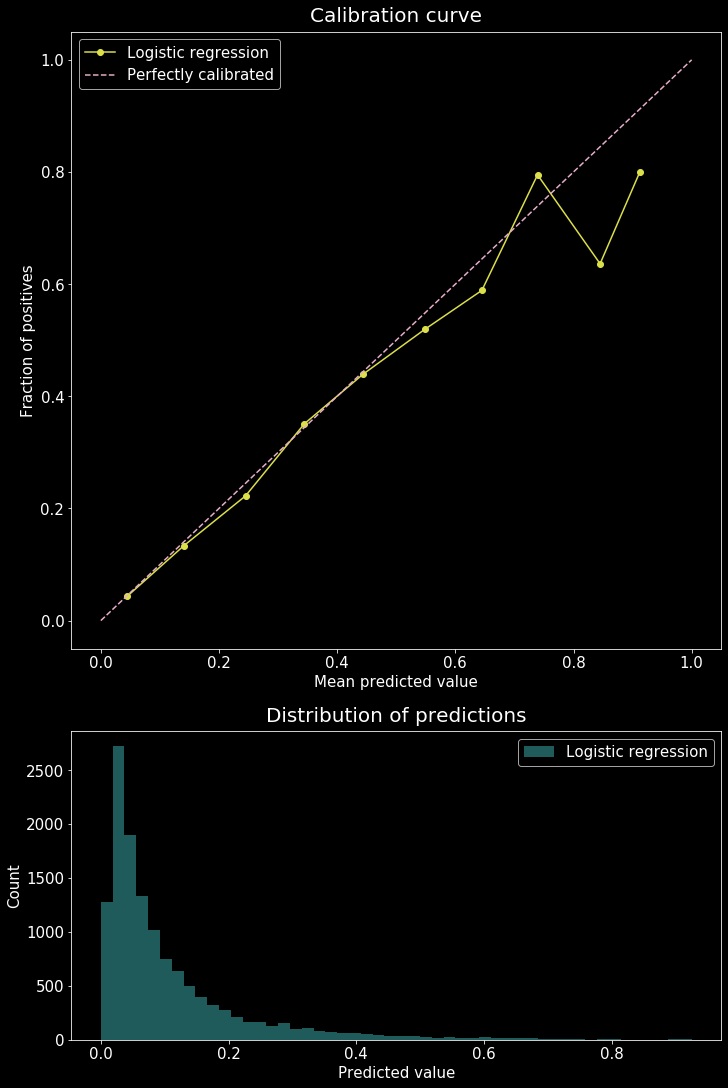

In [17]:
# Plot calibration curve on test data
plt.style.use('dark_background')
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_lr, fraction_of_positives_lr, "-o", color='#dbdf4a', label='Logistic regression')
ax1.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.distplot(y_pred_lr, color='#4fe4e4', label='Logistic regression', kde=False, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10)

In [18]:
print("The log loss of the non-penalty model with Random Search is: " + str(log_loss(y_true_test, y_pred_lr)))
print("The ROC AUC score of the non-penalty model with Random Search is: " +str(roc_auc_score(y_true_test, y_pred_lr)))
print('The McFaddens Pseudo R-squared of the non-penalty model with Random Search is:', mcfadden_r2(y_true_test, y_pred_lr))
print('The Brier score of the non-penalty model with Random Search is:',brier_score_loss(y_true_test, y_pred_lr,
                                                                                         pos_label=y_true_test.max()))

The log loss of the non-penalty model with Random Search is: 0.27531490653208435
The ROC AUC score of the non-penalty model with Random Search is: 0.7836116996353948
The McFaddens Pseudo R-squared of the non-penalty model with Random Search is: 0.16433141479721358
The Brier score of the non-penalty model with Random Search is: 0.0784758892233174


In [19]:
# logistic regression
y_pred_lr_p = logistic_regression_p.predict(x_p_test.astype(float))
y_true_test_p = y_p_test
fraction_of_positives_lr_p, mean_predicted_value_lr_p = calibration_curve(y_true_test_p, y_pred_lr_p, n_bins=10)

Text(0.5, 1.0, 'Distribution of predictions')

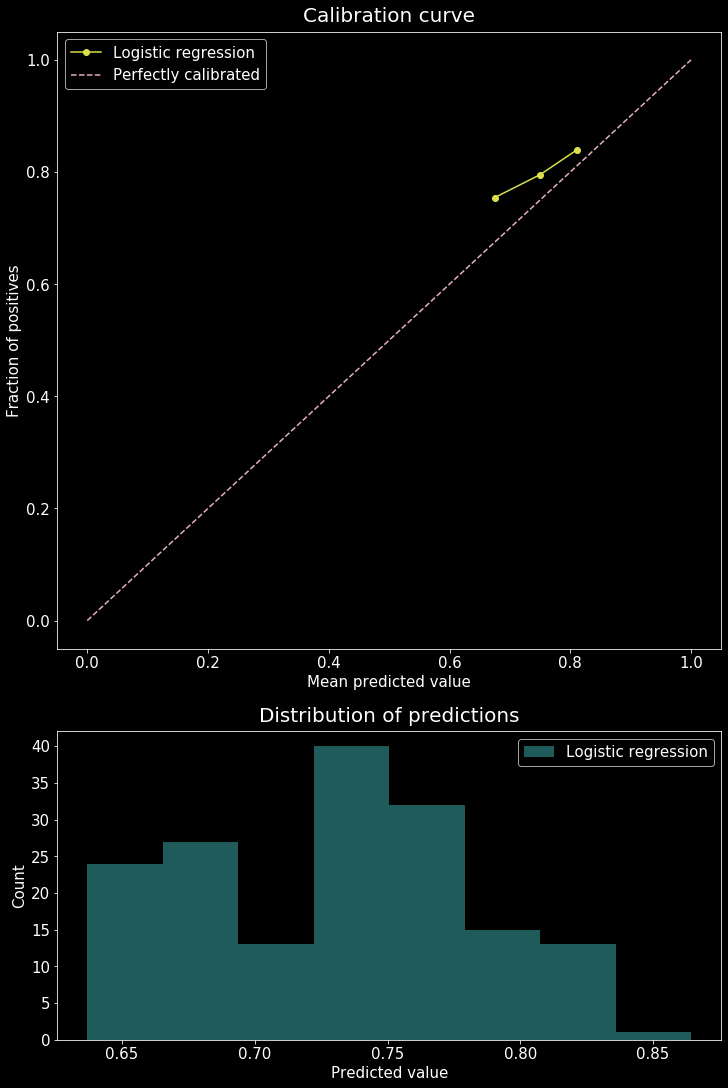

In [20]:
# Plot calibration curve on test data
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_lr_p, fraction_of_positives_lr_p, "-o", color='#dbdf4a', label='Logistic regression')
ax1.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.distplot(y_pred_lr_p, color='#4fe4e4', label='Logistic regression', kde=False, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10)

In [21]:
print("The log loss of the penalty model with Random Search is: " + str(log_loss(y_true_test_p, y_pred_lr_p)))
print("The ROC AUC score of the penalty model with Random Search is: " +str(roc_auc_score(y_true_test_p, y_pred_lr_p)))
print('The McFaddens Pseudo R-squared of the penalty model with Random Search is:', mcfadden_r2(y_true_test_p, y_pred_lr_p))
print('The Brier score of the penalty model with Random Search is:',brier_score_loss(y_true_test_p, y_pred_lr_p,
                                                                         pos_label=y_true_test_p.max()))

The log loss of the penalty model with Random Search is: 0.5231013689260349
The ROC AUC score of the penalty model with Random Search is: 0.5420879120879121
The McFaddens Pseudo R-squared of the penalty model with Random Search is: -0.012283955520718592
The Brier score of the penalty model with Random Search is: 0.16991463650270405


In [22]:
logreg = LogisticRegression(solver='liblinear')
rfe_npp2 = RFE(logreg, 20)
rfe_npp2 = rfe_npp2.fit(x_npp_train, y_npp_train)

x_npp_train2 = x_npp_train.loc[:, rfe_npp2.support_]
x_npp_test2 = x_npp_test.loc[:, rfe_npp2.support_]

In [23]:
logistic_regression_npp = sm.GLM(endog=y_npp_train.astype(float),exog=x_npp_train2.astype(float),data=df_np_pass,
                                           family=sm.families.Binomial()).fit()


In [24]:
train_y_npp_hat = logistic_regression_npp.predict(x_npp_train2.astype(float))
y_pred_lr_npp = logistic_regression_npp.predict(x_npp_test2.astype(float))
naive_train_log_loss_npp = log_loss(y_npp_train, train_y_npp_hat)
naive_train_roc_auc_npp = roc_auc_score(y_npp_train, train_y_npp_hat)
print('The log loss of our non-penalty pass model on the training set is : ' +str(round(naive_train_log_loss_npp, 4)))
print('The ROC AUC of our non-penalty pass model on the training set is : ' +str(round(naive_train_roc_auc_npp, 4)))
print("McFadden's Pseudo R-squared shots assisted by passes : "  +str(round( mcfadden_r2(y_npp_train, train_y_npp_hat), 4)))

The log loss of our non-penalty pass model on the training set is : 0.2922
The ROC AUC of our non-penalty pass model on the training set is : 0.7832
McFadden's Pseudo R-squared shots assisted by passes : 0.1599


In [33]:
print(logistic_regression_npp.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                35198
Model:                            GLM   Df Residuals:                    35178
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10286.
Date:                Tue, 07 Sep 2021   Deviance:                       20572.
Time:                        10:14:24   Pearson chi2:                 3.45e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
visibl

In [ ]:
rfe_npo2 = RFE(logreg, 20)
rfe_npo2 = rfe_npo2.fit(x_npo_train, y_npo_train)

x_npo_train2 = x_npo_train.loc[:, rfe_npo2.support_]
x_npo_test2 = x_npo_test.loc[:, rfe_npo2.support_]

In [ ]:
logistic_regression_npo = sm.GLM(endog=y_npo_train.astype(float),exog=x_npo_train2.astype(float),data=df_np_other,
                                           family=sm.families.Binomial()).fit()

In [25]:
train_y_npo_hat = logistic_regression_npo.predict(x_npo_train2.astype(float))
y_pred_lr_npo = logistic_regression_npo.predict(x_npo_test2.astype(float))
naive_train_log_loss_npo = log_loss(y_npo_train, train_y_npo_hat)
naive_train_roc_auc_npo = roc_auc_score(y_npo_train, train_y_npo_hat)
print('The log loss of our non-penalty other model on the training set is : ' +str(round(naive_train_log_loss_npo, 4)))
print('The ROC AUC of our non-penalty other model on the training set is : ' +str(round(naive_train_roc_auc_npo, 4)))
print("McFadden's Pseudo R-squared shots assisted by passes : "  +str(round( mcfadden_r2(y_npp_train, train_y_npp_hat), 4)))

The log loss of our non-penalty other model on the training set is : 0.2613
The ROC AUC of our non-penalty other model on the training set is : 0.8073
McFadden's Pseudo R-squared shots assisted by passes : 0.1599


In [34]:
print(logistic_regression_npo.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                16406
Model:                            GLM   Df Residuals:                    16387
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4287.6
Date:                Tue, 07 Sep 2021   Deviance:                       8575.3
Time:                        10:14:25   Pearson chi2:                 1.61e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
visible_an

In [ ]:
rfe_p2 = RFE(logreg, 8)
rfe_p2 = rfe_p2.fit(x_p_train, y_p_train)

x_p_train2 = x_p_train.loc[:, rfe_p2.support_]
x_p_test2 = x_p_test.loc[:, rfe_p2.support_]

In [ ]:
logistic_regression_p = sm.GLM(endog=y_p_train.astype(float),exog=x_p_train2.astype(float),data=df_p,
                                           family=sm.families.Binomial()).fit()

In [26]:
train_y_p_hat = logistic_regression_p.predict(x_p_train2.astype(float))
naive_train_log_loss_p = log_loss(y_p_train, train_y_p_hat)
naive_train_roc_auc_p = roc_auc_score(y_p_train, train_y_p_hat)
print('The log loss of our penalty model on the training set is : ' +str(round(naive_train_log_loss_p, 4)))
print('The ROC AUC of our penalty model on the training set is : ' +str(round(naive_train_roc_auc_p, 4)))
print("McFadden's Pseudo R-squared penaltys : "  +str(round( mcfadden_r2(y_p_train, train_y_p_hat), 4)))

The log loss of our penalty model on the training set is : 0.5787
The ROC AUC of our penalty model on the training set is : 0.5707
McFadden's Pseudo R-squared penaltys : 0.01


In [35]:
print(logistic_regression_p.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                  656
Model:                            GLM   Df Residuals:                      648
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -379.65
Date:                Tue, 07 Sep 2021   Deviance:                       759.29
Time:                        10:14:25   Pearson chi2:                     655.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
players                    0

In [27]:
# logistic regression
y_pred_lr = np.concatenate([y_pred_lr_npp, y_pred_lr_npo])
y_true_test = np.concatenate([y_npp_test, y_npo_test])
fraction_of_positives_lr, mean_predicted_value_lr = calibration_curve(y_true_test, y_pred_lr, n_bins=10)

Text(0.5, 1.0, 'Distribution of predictions')

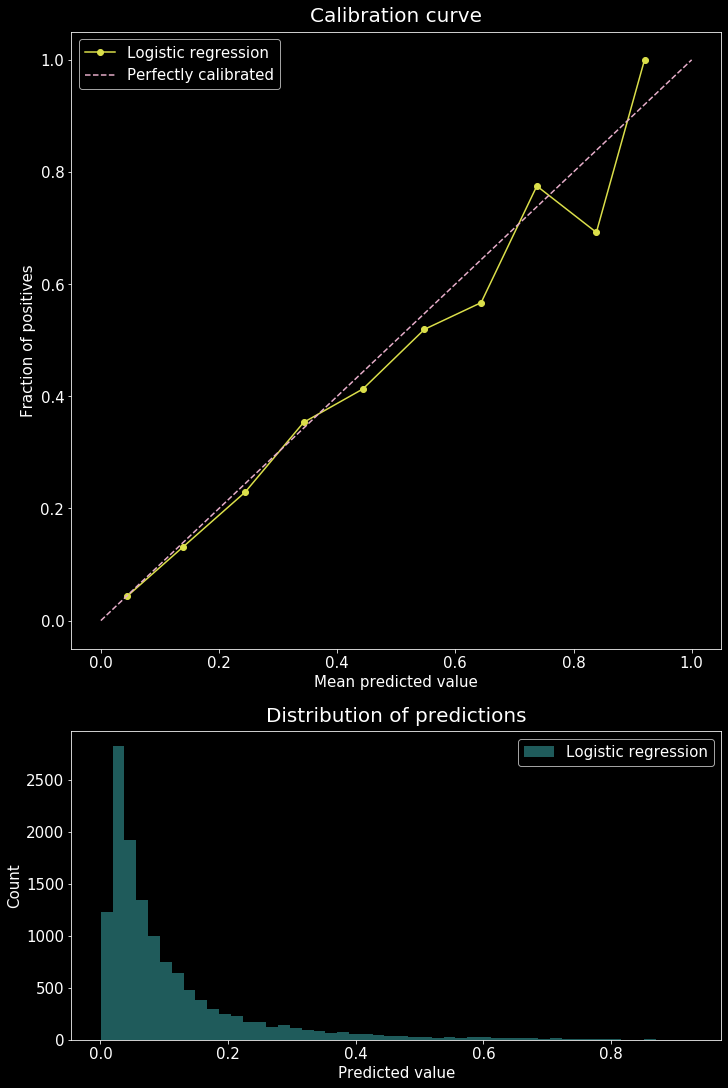

In [28]:
# Plot calibration curve on test data
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_lr, fraction_of_positives_lr, "-o", color='#dbdf4a', label='Logistic regression')
ax1.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.distplot(y_pred_lr, color='#4fe4e4', label='Logistic regression', kde=False, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10)

In [29]:
print("The log loss of the non-penalty model with Random Search is: " + str(log_loss(y_true_test, y_pred_lr)))
print("The ROC AUC score of the non-penalty model with Random Search is: " +str(roc_auc_score(y_true_test, y_pred_lr)))
print('The McFaddens Pseudo R-squared of the non-penalty model with Random Search is:', mcfadden_r2(y_true_test, y_pred_lr))
print('The Brier score of the non-penalty model with Random Search is:',brier_score_loss(y_true_test, y_pred_lr,
                                                                                         pos_label=y_true_test.max()))

The log loss of the non-penalty model with Random Search is: 0.2753986579673347
The ROC AUC score of the non-penalty model with Random Search is: 0.7834776092307192
The McFaddens Pseudo R-squared of the non-penalty model with Random Search is: 0.16407720246891666
The Brier score of the non-penalty model with Random Search is: 0.07857147009949797


In [30]:
# logistic regression
y_pred_lr_p = logistic_regression_p.predict(x_p_test2.astype(float))
y_true_test_p = y_p_test
fraction_of_positives_lr_p, mean_predicted_value_lr_p = calibration_curve(y_true_test_p, y_pred_lr_p, n_bins=10)

Text(0.5, 1.0, 'Distribution of predictions')

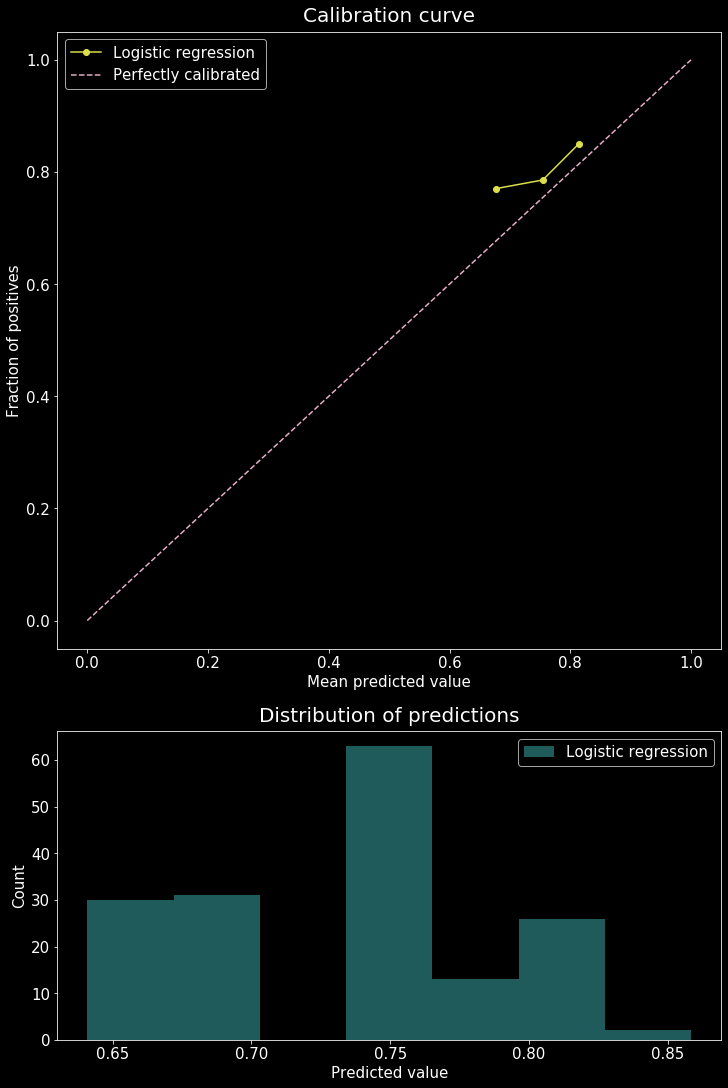

In [31]:
# Plot calibration curve on test data
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_lr_p, fraction_of_positives_lr_p, "-o", color='#dbdf4a', label='Logistic regression')
ax1.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.distplot(y_pred_lr_p, color='#4fe4e4', label='Logistic regression', kde=False, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10)

In [32]:
print("The log loss of the penalty model with Random Search is: " + str(log_loss(y_true_test_p, y_pred_lr_p)))
print("The ROC AUC score of the penalty model with Random Search is: " +str(roc_auc_score(y_true_test_p, y_pred_lr_p)))
print('The McFaddens Pseudo R-squared of the penalty model with Random Search is:', mcfadden_r2(y_true_test_p, y_pred_lr_p))
print('The Brier score of the penalty model with Random Search is:',brier_score_loss(y_true_test_p, y_pred_lr_p,
                                                                         pos_label=y_true_test_p.max()))

The log loss of the penalty model with Random Search is: 0.5237994527503489
The ROC AUC score of the penalty model with Random Search is: 0.547912087912088
The McFaddens Pseudo R-squared of the penalty model with Random Search is: -0.013634858227038249
The Brier score of the penalty model with Random Search is: 0.17024030696620465


In [36]:
logreg = LogisticRegression(solver='liblinear')
rfe_npp3 = RFE(logreg, 12)
rfe_npp3 = rfe_npp3.fit(x_npp_train, y_npp_train)

x_npp_train3 = x_npp_train.loc[:, rfe_npp3.support_]
x_npp_test3 = x_npp_test.loc[:, rfe_npp3.support_]

In [38]:
logistic_regression_npp = sm.GLM(endog=y_npp_train.astype(float),exog=x_npp_train3.astype(float),data=df_np_pass,
                                           family=sm.families.Binomial()).fit()

In [39]:
train_y_npp_hat = logistic_regression_npp.predict(x_npp_train3.astype(float))
y_pred_lr_npp = logistic_regression_npp.predict(x_npp_test3.astype(float))
naive_train_log_loss_npp = log_loss(y_npp_train, train_y_npp_hat)
naive_train_roc_auc_npp = roc_auc_score(y_npp_train, train_y_npp_hat)
print('The log loss of our non-penalty pass model on the training set is : ' +str(round(naive_train_log_loss_npp, 4)))
print('The ROC AUC of our non-penalty pass model on the training set is : ' +str(round(naive_train_roc_auc_npp, 4)))
print("McFadden's Pseudo R-squared shots assisted by passes : "  +str(round( mcfadden_r2(y_npp_train, train_y_npp_hat), 4)))

The log loss of our non-penalty pass model on the training set is : 0.2928
The ROC AUC of our non-penalty pass model on the training set is : 0.7818
McFadden's Pseudo R-squared shots assisted by passes : 0.1582


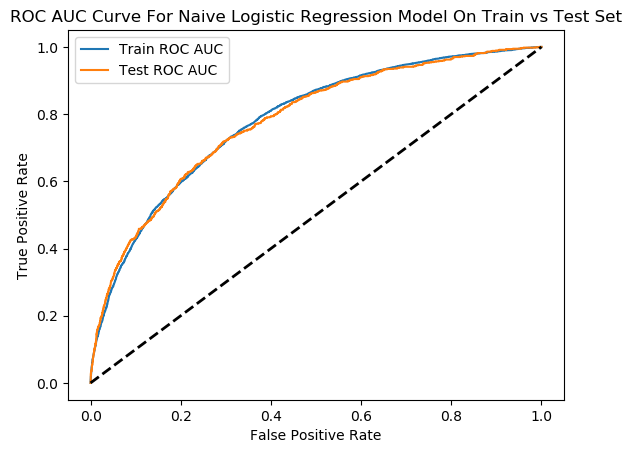

In [40]:
plt.style.use('default')
test_y_npp_hat = logistic_regression_npp.predict(x_npp_test3.astype(float))
train_npp_fpr, train_npp_tpr, train_npp_thresholds = roc_curve(y_true=y_npp_train, y_score=train_y_npp_hat)
test_npp_fpr, test_npp_tpr, test_npp_thresholds = roc_curve(y_true=y_npp_test, y_score=test_y_npp_hat)
plt.plot(train_npp_fpr, train_npp_tpr, label = 'Train ROC AUC')
plt.plot(test_npp_fpr, test_npp_tpr, label = 'Test ROC AUC')
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC AUC Curve For Naive Logistic Regression Model On Train vs Test Set')
plt.show()

In [51]:
print(logistic_regression_npp.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                35198
Model:                            GLM   Df Residuals:                    35186
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10306.
Date:                Tue, 07 Sep 2021   Deviance:                       20613.
Time:                        10:14:33   Pearson chi2:                 3.44e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
visibl

In [ ]:
rfe_npo3 = RFE(logreg, 15)
rfe_npo3 = rfe_npo3.fit(x_npo_train, y_npo_train)

x_npo_train3 = x_npo_train.loc[:, rfe_npo3.support_]
x_npo_test3 = x_npo_test.loc[:, rfe_npo3.support_]

In [ ]:
logistic_regression_npo = sm.GLM(endog=y_npo_train.astype(float),exog=x_npo_train3.astype(float),data=df_np_other,
                                           family=sm.families.Binomial()).fit()

In [41]:
train_y_npo_hat = logistic_regression_npo.predict(x_npo_train3.astype(float))
y_pred_lr_npo = logistic_regression_npo.predict(x_npo_test3.astype(float))
naive_train_log_loss_npo = log_loss(y_npo_train, train_y_npo_hat)
naive_train_roc_auc_npo = roc_auc_score(y_npo_train, train_y_npo_hat)
print('The log loss of our non-penalty other model on the training set is : ' +str(round(naive_train_log_loss_npo, 4)))
print('The ROC AUC of our non-penalty other model on the training set is : ' +str(round(naive_train_roc_auc_npo, 4)))
print("McFadden's Pseudo R-squared shots assisted by passes : "  +str(round( mcfadden_r2(y_npp_train, train_y_npp_hat), 4)))

The log loss of our non-penalty other model on the training set is : 0.2617
The ROC AUC of our non-penalty other model on the training set is : 0.8067
McFadden's Pseudo R-squared shots assisted by passes : 0.1582


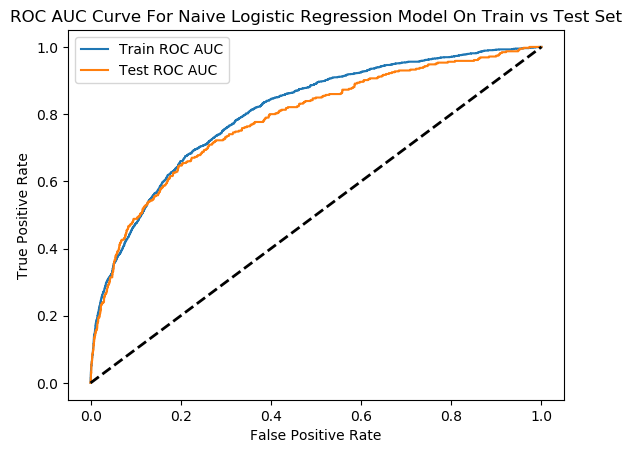

In [42]:
test_y_npo_hat = logistic_regression_npo.predict(x_npo_test3.astype(float))
train_npo_fpr, train_npo_tpr, train_npo_thresholds = roc_curve(y_true=y_npo_train, y_score=train_y_npo_hat)
test_npo_fpr, test_npo_tpr, test_npo_thresholds = roc_curve(y_true=y_npo_test, y_score=test_y_npo_hat)
plt.plot(train_npo_fpr, train_npo_tpr, label = 'Train ROC AUC')
plt.plot(test_npo_fpr, test_npo_tpr, label = 'Test ROC AUC')
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC AUC Curve For Naive Logistic Regression Model On Train vs Test Set')
plt.show()

In [52]:
print(logistic_regression_npo.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                16406
Model:                            GLM   Df Residuals:                    16392
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4294.1
Date:                Tue, 07 Sep 2021   Deviance:                       8588.2
Time:                        10:14:34   Pearson chi2:                 1.60e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
visible_an

In [ ]:
rfe_p3 = RFE(logreg, 1)
rfe_p3 = rfe_p3.fit(x_p_train, y_p_train)

x_p_train3 = x_p_train.loc[:, rfe_p3.support_]
x_p_test3 = x_p_test.loc[:, rfe_p3.support_]

In [ ]:
logistic_regression_p = sm.GLM(endog=y_p_train.astype(float),exog=x_p_train3.astype(float),data=df_p,
                                           family=sm.families.Binomial()).fit()

In [43]:
train_y_p_hat = logistic_regression_p.predict(x_p_train3.astype(float))
naive_train_log_loss_p = log_loss(y_p_train, train_y_p_hat)
naive_train_roc_auc_p = roc_auc_score(y_p_train, train_y_p_hat)
print('The log loss of our penalty model on the training set is : ' +str(round(naive_train_log_loss_p, 4)))
print('The ROC AUC of our penalty model on the training set is : ' +str(round(naive_train_roc_auc_p, 4)))
print("McFadden's Pseudo R-squared penaltys : "  +str(round( mcfadden_r2(y_p_train, train_y_p_hat), 4)))

The log loss of our penalty model on the training set is : 0.5845
The ROC AUC of our penalty model on the training set is : 0.5022
McFadden's Pseudo R-squared penaltys : 0.0001


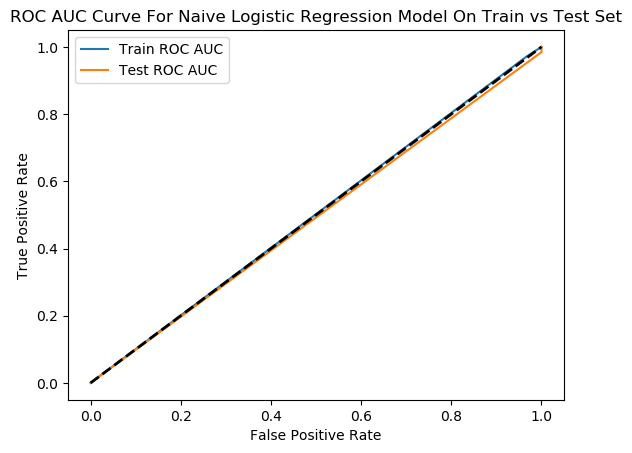

In [44]:
test_y_p_hat = logistic_regression_p.predict(x_p_test3.astype(float))
train_p_fpr, train_p_tpr, train_p_thresholds = roc_curve(y_true=y_p_train, y_score=train_y_p_hat)
test_p_fpr, test_p_tpr, test_p_thresholds = roc_curve(y_true=y_p_test, y_score=test_y_p_hat)
plt.plot(train_p_fpr, train_p_tpr, label = 'Train ROC AUC')
plt.plot(test_p_fpr, test_p_tpr, label = 'Test ROC AUC')
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC AUC Curve For Naive Logistic Regression Model On Train vs Test Set')
plt.show()

In [53]:
print(logistic_regression_p.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                  656
Model:                            GLM   Df Residuals:                      655
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -383.45
Date:                Tue, 07 Sep 2021   Deviance:                       766.91
Time:                        10:14:34   Pearson chi2:                     656.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
players        0.0901      0.008     11.252      0.0

In [45]:
# logistic regression
y_pred_lr = np.concatenate([y_pred_lr_npp, y_pred_lr_npo])
y_true_test = np.concatenate([y_npp_test, y_npo_test])
fraction_of_positives_lr, mean_predicted_value_lr = calibration_curve(y_true_test, y_pred_lr, n_bins=10)

Text(0.5, 1.0, 'Distribution of predictions')

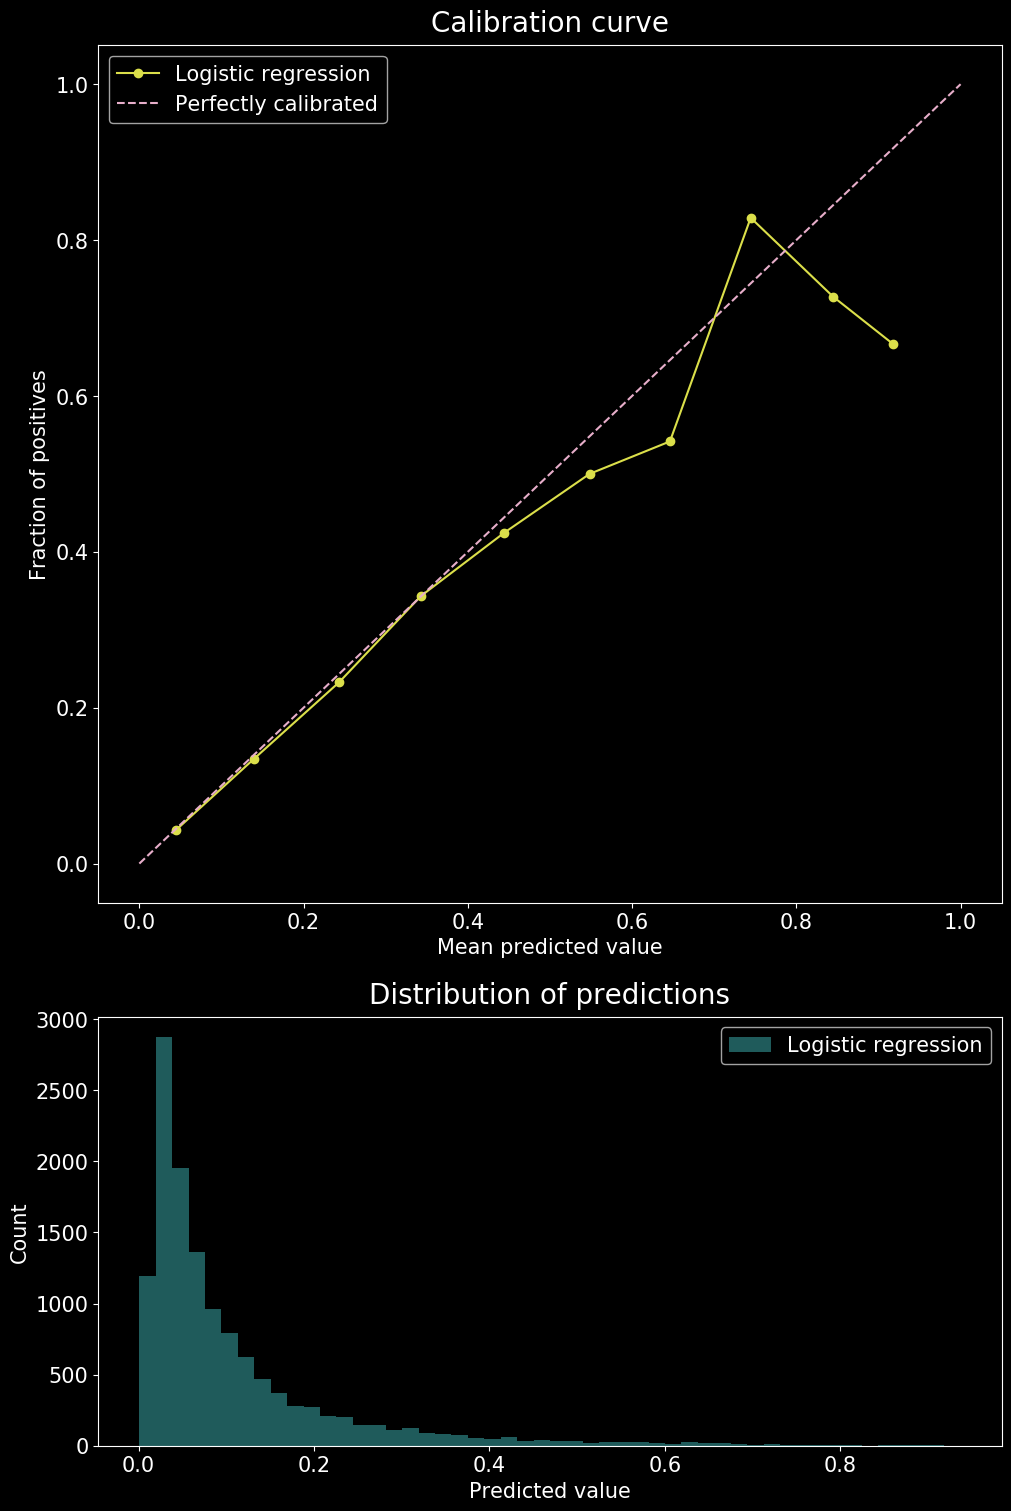

In [46]:
# Plot calibration curve on test data
plt.style.use('dark_background')
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_lr, fraction_of_positives_lr, "-o", color='#dbdf4a', label='Logistic regression')
ax1.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.distplot(y_pred_lr, color='#4fe4e4', label='Logistic regression', kde=False, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10)

In [ ]:
print("The log loss of the non-penalty model with Random Search is: " + str(log_loss(y_true_test, y_pred_lr)))
print("The ROC AUC score of the non-penalty model with Random Search is: " +str(roc_auc_score(y_true_test, y_pred_lr)))
print('The McFaddens Pseudo R-squared of the non-penalty model with Random Search is:', mcfadden_r2(y_true_test, y_pred_lr))
print('The Brier score of the non-penalty model with Random Search is:',brier_score_loss(y_true_test, y_pred_lr,
                                                                                         pos_label=y_true_test.max()))

In [48]:
# logistic regression
y_pred_lr_p = logistic_regression_p.predict(x_p_test3.astype(float))
y_true_test_p = y_p_test
fraction_of_positives_lr_p, mean_predicted_value_lr_p = calibration_curve(y_true_test_p, y_pred_lr_p, n_bins=10)

Text(0.5, 1.0, 'Distribution of predictions')

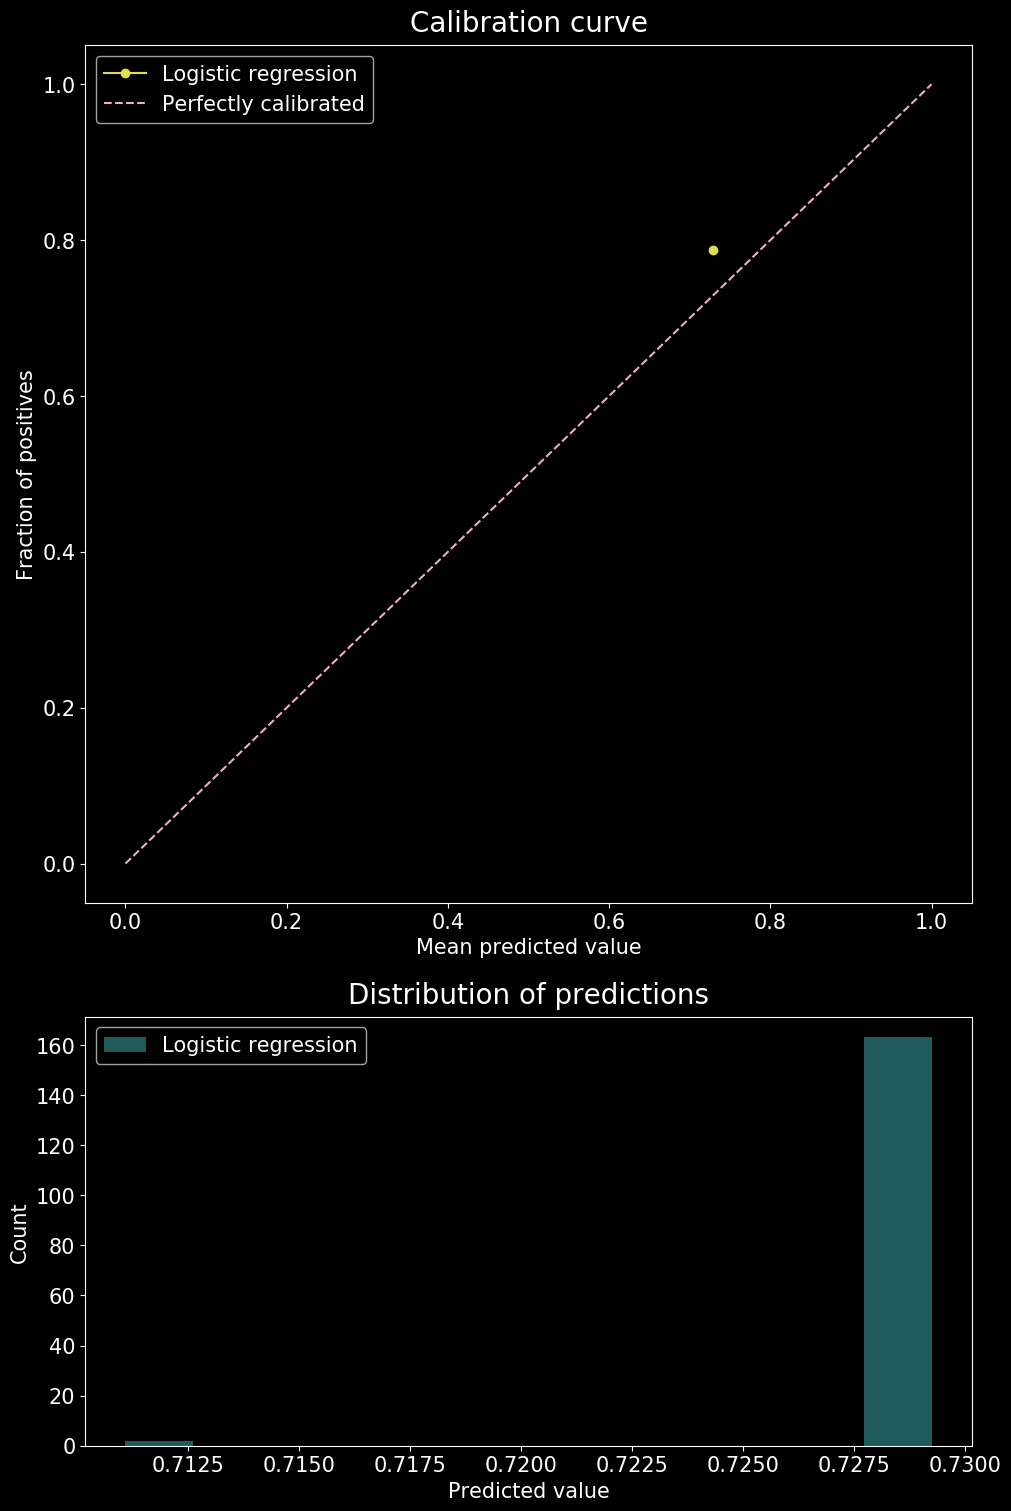

In [49]:
# Plot calibration curve on test data
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_lr_p, fraction_of_positives_lr_p, "-o", color='#dbdf4a', label='Logistic regression')
ax1.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.distplot(y_pred_lr_p, color='#4fe4e4', label='Logistic regression', kde=False, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10)

In [50]:
print("The log loss of the penalty model with Random Search is: " + str(log_loss(y_true_test_p, y_pred_lr_p)))
print("The ROC AUC score of the penalty model with Random Search is: " +str(roc_auc_score(y_true_test_p, y_pred_lr_p)))
print('The McFaddens Pseudo R-squared of the penalty model with Random Search is:', mcfadden_r2(y_true_test_p, y_pred_lr_p))
print('The Brier score of the penalty model with Random Search is:',brier_score_loss(y_true_test_p, y_pred_lr_p,
                                                                         pos_label=y_true_test_p.max()))

The log loss of the penalty model with Random Search is: 0.5262204225260716
The ROC AUC score of the penalty model with Random Search is: 0.49230769230769234
The McFaddens Pseudo R-squared of the penalty model with Random Search is: -0.018319817981198527
The Brier score of the penalty model with Random Search is: 0.1706871162053071


# Save models

In [54]:
dump(logistic_regression_npp, os.path.join(cwd, 'models', 'lr_pass2.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\lr_pass2.joblib']

In [55]:
dump(logistic_regression_npo, os.path.join(cwd, 'models', 'lr_other2.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\lr_other2.joblib']

In [56]:
dump(logistic_regression_p, os.path.join(cwd, 'models', 'lr_penalty2.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\lr_penalty2.joblib']

# Save data

In [57]:
# reload shot dataset for ids
df = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
df = df[['match_id', 'wyscout_id', 'statsbomb_id']].copy()

In [58]:
x_npo_train3['goal'] = y_npo_train
x_npo_train3['split'] = 'train'
x_npo_test3['goal'] = y_npo_test
x_npo_test3['split'] = 'test'
df_other = pd.concat([x_npo_train3, x_npo_test3])
df_other = df_other.merge(df, left_index=True, right_index=True, validate='1:1', how='left')
df_other.reset_index(drop=True, inplace=True)
df_other.to_parquet(os.path.join(cwd, 'data', 'modelling', 'lr_other2.parquet'))

In [59]:
x_npp_train3['goal'] = y_npp_train
x_npp_train3['split'] = 'train'
x_npp_test3['goal'] = y_npp_test
x_npp_test3['split'] = 'test'
df_pass = pd.concat([x_npp_train3, x_npp_test3])
df_pass = df_pass.merge(df, left_index=True, right_index=True, validate='1:1', how='left')
df_pass.reset_index(drop=True, inplace=True)
df_pass.to_parquet(os.path.join(cwd, 'data', 'modelling', 'lr_pass2.parquet'))

In [60]:
x_p_train3['goal'] = y_p_train
x_p_train3['split'] = 'train'
x_p_test3['goal'] = y_p_test
x_p_test3['split'] = 'test'
df_penalty = pd.concat([x_p_train3, x_p_test3])
df_penalty = df_penalty.merge(df, left_index=True, right_index=True, validate='1:1', how='left')
df_penalty.reset_index(drop=True, inplace=True)
df_penalty.to_parquet(os.path.join(cwd, 'data', 'modelling', 'lr_penalty2.parquet'))